In [2]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import os, sys
from time import time

from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web

import statsmodels.api as sm
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import scale
import lightgbm as lgb
from scipy.stats import spearmanr
from tqdm import tqdm
import shap

import talib
import matplotlib.pyplot as plt
import seaborn as sns


def make_target(df, num_day_rise=1):
    df["target"] = df.groupby(by=['symbol']).apply(
        lambda x: pd.DataFrame(pd.Series(talib.ROC(x.close, num_day_rise)).shift(-1 * num_day_rise), index=x.index)
    )
    return df


In [3]:
filepath = "df_predict_work.csv"
ori_df = pd.read_csv(filepath, index_col=0)

df = make_target(ori_df, num_day_rise=1)
df.to_csv("df_predict_work_target_df.csv")
print(df)

            symbol             datetime exchange    open    high     low  \
0       1inch_usdt  2020-12-25 08:00:00  BINANCE  0.2000  3.0885  0.2000   
1       1inch_usdt  2020-12-26 08:00:00  BINANCE  2.2958  2.4609  1.5717   
2       1inch_usdt  2020-12-27 08:00:00  BINANCE  1.5970  1.6516  1.0360   
3       1inch_usdt  2020-12-28 08:00:00  BINANCE  1.0600  1.2787  1.0353   
4       1inch_usdt  2020-12-29 08:00:00  BINANCE  1.1140  1.1166  0.7541   
...            ...                  ...      ...     ...     ...     ...   
136590    zrx_usdt  2021-10-07 08:00:00  BINANCE  1.0372  1.0419  0.9939   
136591    zrx_usdt  2021-10-08 08:00:00  BINANCE  1.0283  1.1100  1.0101   
136592    zrx_usdt  2021-10-09 08:00:00  BINANCE  1.0840  1.1194  1.0497   
136593    zrx_usdt  2021-10-10 08:00:00  BINANCE  1.1171  1.1288  1.0323   
136594    zrx_usdt  2021-10-11 08:00:00  BINANCE  1.0451  1.0768  1.0272   

         close        volume  DROC5  DROC10  ...       SAR  AROON_UP  \
0       2.2954 

In [103]:
from sklearn.model_selection import train_test_split
#data:需要进行分割的数据集
#random_state:设置随机种子，保证每次运行生成相同的随机数
#test_size:将数据分割成训练集的比例
df = df.dropna()

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

#fwd_returns = df.filter(like='target').columns
fwd_returns = ["target"]
print(fwd_returns)

features = df.columns.difference(pd.Index(list(fwd_returns) + ['symbol', 'datetime', 'exchange', 'open', 'high', 'low', 'close', 'volume'])).tolist()
print(features)

X_train = train_set.loc[:, features]
print(X_train)

Y_train = train_set.loc[:, fwd_returns]
print(Y_train)

X_test = test_set.loc[:, features]
print(X_test)

Y_test = test_set.loc[:, fwd_returns]
print(Y_test)


['target']
['AD', 'ADOSC', 'ADX', 'AROON_DOWN', 'AROON_UP', 'ATR', 'BOLL_LOWER', 'BOLL_MIDDLE', 'BOLL_UPPER', 'BOP', 'CCI', 'CMO', 'DER10', 'DER120', 'DER20', 'DER30', 'DER60', 'DER90', 'DROC10', 'DROC20', 'DROC30', 'DROC5', 'DROC60', 'DROC90', 'EMA', 'ER10', 'ER120', 'ER20', 'ER30', 'ER60', 'ER90', 'HT_TRENDLINE', 'MA10', 'MA120', 'MA20', 'MA30', 'MA5', 'MA60', 'MACD', 'MACDHIST', 'MACDSIGNAL', 'MOM', 'NATR', 'NEGNATR', 'OBV', 'PPO', 'ROC1', 'ROC10', 'ROC20', 'ROC3', 'ROC30', 'ROC5', 'ROC60', 'ROC90', 'RSI14', 'SAR', 'SIZE', 'SLOWD', 'TRIX14', 'ULTOSC', 'WILLR', 'WMA']
                 AD         ADOSC        ADX  AROON_DOWN    AROON_UP  \
49162 -6.635228e+06 -1.125810e+05  22.749606    0.000000   92.857143   
5739  -1.957714e+07  1.155250e+05  11.532208   42.857143  100.000000   
17619  3.180305e+08  2.458142e+06  21.109520   71.428571   14.285714   
24601 -1.059123e+10  1.856034e+07  22.309077   35.714286   71.428571   
44788  1.282549e+08  2.338962e+06  35.233627  100.000000    0.0

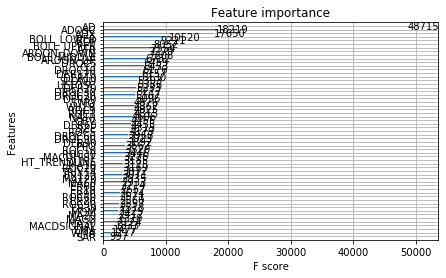

In [23]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree


best_params = {'gamma': 0.01, 'learning_rate': 0.05, 'max_depth': 15, 'n_estimators': 400, 'random_state': 42}

model = xgb.XGBRegressor(**best_params)
model.fit(X_train, Y_train, verbose=False)

plot_importance(model)



In [60]:
from sklearn.metrics import mean_squared_error

def cal_spearman(Y_test, Y_pred):
    return pd.Series(list(Y_test["target"])).corr(pd.Series(list(Y_pred)),method="spearman")

def cal_predict_rate(Y_test, Y_pred, rate=0.5, fee_rate=0.4):
    Y_test = list(Y_test["target"])
    Y_pred = list(Y_pred)
    num = 0
    sum_inc = 0
    avg_inc = 0
    for i in range(len(Y_test)):
        if Y_pred[i] > rate:
            sum_inc += Y_test[i] - fee_rate
            num += 1
        elif Y_pred[i] < -rate:
            sum_inc += -1 * Y_test[i] - fee_rate
            num += 1
    avg_inc = sum_inc * 1.0 / num
    return sum_inc, avg_inc

Y_pred = model.predict(X_test)
print(f'Y_true = {np.array(Y_test)[:5]}')
print(f'Y_pred = {Y_pred[:5]}')

print(f'mean_squared_error = {mean_squared_error(Y_test, Y_pred)}')
print(f'spearman = {cal_spearman(Y_test, Y_pred)}')

sum_inc, avg_inc = cal_predict_rate(Y_test, Y_pred)
print(f'sum_inc:{sum_inc} avg_inc:{avg_inc}')


Y_true = [[ 8.54132901]
 [ 0.66980286]
 [-2.        ]
 [ 1.64707877]
 [-0.87357779]]
Y_pred = [ 1.3675802  -0.34835124  0.97745913  0.24745458  0.3469833 ]
mean_squared_error = 82.26499032487042
spearman = 0.29217303524968097
sum_inc:10270.929724964448 avg_inc:1.9062601568233941


Index(['target'], dtype='object')
['AD', 'ADOSC', 'ADX', 'AROON_DOWN', 'AROON_UP', 'ATR', 'BOLL_LOWER', 'BOLL_MIDDLE', 'BOLL_UPPER', 'BOP', 'CCI', 'CMO', 'DER10', 'DER120', 'DER20', 'DER30', 'DER60', 'DER90', 'DROC10', 'DROC20', 'DROC30', 'DROC5', 'DROC60', 'DROC90', 'EMA', 'ER10', 'ER120', 'ER20', 'ER30', 'ER60', 'ER90', 'HT_TRENDLINE', 'MA10', 'MA120', 'MA20', 'MA30', 'MA5', 'MA60', 'MACD', 'MACDHIST', 'MACDSIGNAL', 'MOM', 'NATR', 'NEGNATR', 'OBV', 'PPO', 'ROC1', 'ROC10', 'ROC20', 'ROC3', 'ROC30', 'ROC5', 'ROC60', 'ROC90', 'RSI14', 'SAR', 'SIZE', 'SLOWD', 'TRIX14', 'ULTOSC', 'WILLR', 'WMA']
end start_datetime: 2018-01-31 00:00:00
176.27218212986259
end start_datetime: 2018-03-02 00:00:00
425.4151972364618
end start_datetime: 2018-04-01 00:00:00
321.7214977540099
end start_datetime: 2018-05-01 00:00:00
363.09734753162104
end start_datetime: 2018-05-31 00:00:00
-405.3850961765843
end start_datetime: 2018-06-30 00:00:00
-382.72170028209143
end start_datetime: 2018-07-30 00:00:00
-488.64

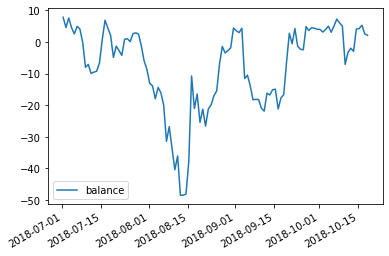

In [5]:
import xgboost as xgb
# class RollingModel(object):
#     def __init__(self, start_datetime, end_datetime, )
from datetime import datetime, timedelta

from tumbler.function import get_sum_dic
import tumbler.function.figure as figure
from tumbler.function.technique import PD_Technique

def func_create_model():
    best_params = {'gamma': 0.01, 'learning_rate': 0.05, 'max_depth': 15, 'n_estimators': 400, 'random_state': 42}
    model = xgb.XGBRegressor(**best_params)
    return model


def rolling_model(func_create_model, ori_df, start_datetime, end_datetime, features=[], 
                  fwd_returns = [], train_days=180, predict_days=30, rate=0.5, fee_rate=0.2):
    all_sum = 0
    sum_income_arr = []
    day_rise_dic = {}
    while start_datetime + timedelta(days=train_days + predict_days) <= end_datetime:
        train_start_datetime = start_datetime
        train_end_datetime = start_datetime + timedelta(days=train_days)
        
        predict_start_datetime = train_end_datetime + timedelta(days=1)
        predict_end_datetime = train_end_datetime + timedelta(days=predict_days + 1)
        
        #print(train_start_datetime, train_end_datetime, predict_start_datetime, predict_end_datetime)
        
        train_df = ori_df[ori_df.datetime >= str(train_start_datetime)]
        train_df = train_df[train_df.datetime <= str(train_end_datetime)]

        test_df = ori_df[ori_df.datetime >= str(predict_start_datetime)]
        test_df = test_df[test_df.datetime <= str(predict_end_datetime)]
        
        if len(train_df.index) > 0 and len(test_df.index) > 0:
            X_train = train_df.loc[:, features]
            Y_train = train_df.loc[:, fwd_returns]
            X_test = test_df.loc[:, features]
            Y_test = test_df.loc[:, fwd_returns]
        
            model = func_create_model()
            model.fit(X_train, Y_train, verbose=False)
            
            Y_pred = model.predict(X_test)
            
            y_pos_arr = []
            for i in range(len(list(Y_pred))):
                if Y_pred[i] > rate:
                    y_pos_arr.append(1)
                elif Y_pred[i] < -1 * rate:
                    y_pos_arr.append(-1)
                else:
                    y_pos_arr.append(0)
            
            test_df["pos"] = y_pos_arr
            test_df["income"] = y_pos_arr * test_df["target"]
            test_df["Y_pred"] = Y_pred
            
            sum_dt = test_df.groupby(['datetime'])['income'].sum()
            sum_income_arr.append(sum_dt.copy())
            
            val = sum(list(sum_dt))
            all_sum += val
            
            for ind in test_df.index:
                dt = test_df.loc[ind, 'datetime']
                real_rise = test_df.loc[ind, 'target']
                predict_rise = test_df.loc[ind, 'Y_pred']
                
                if dt not in day_rise_dic.keys():
                    day_rise_dic[dt] = []
                day_rise_dic[dt].append([predict_rise, real_rise])
        
        #print("bef start_datetime:", start_datetime)
        start_datetime += timedelta(days=predict_days)
        print("end start_datetime:", start_datetime)
        print(all_sum)
    
    all_income_pd_series = pd.concat(sum_income_arr)
    print(all_income_pd_series)
    all_income_pd_series.to_csv("sum_pd.csv")
    
    dt_arr = list(day_rise_dic.keys())
    dt_arr.sort(reverse=True)
    sum_rise_dic = {}
    for dt in dt_arr:
        sum_rise_dic[dt] = 0
        arr = day_rise_dic[dt]
        arr.sort(reverse=True)
        n = 0
        for predict_rise, real_rise in arr[:10]:
            n = n + 1
            sum_rise_dic[dt] += real_rise
        if n > 0:
            sum_rise_dic[dt] = sum_rise_dic[dt] / n
            
    sum_income_dic = get_sum_dic(sum_rise_dic)
    strategy_info = PD_Technique.assume_dic(sum_income_dic)
    print(strategy_info)
    figure.dic_plot(sum_income_dic)
    

fwd_returns = df.filter(like='target').columns
print(fwd_returns)

features = df.columns.difference(pd.Index(list(fwd_returns) + ['symbol', 'datetime', 'exchange', 'open', 'high', 'low', 'close', 'volume'])).tolist()
print(features)

rolling_model(func_create_model, ori_df,  datetime(2018, 1, 1), datetime.now(), features, fwd_returns, 180, 30, rate=0.2, fee_rate=0)
